In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
 
# Text Pre-processing libraries
import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
 
# Tensorflow imports to build the model.
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

C:\Users\mahes\AppData\Local\Temp\ipykernel_16876\1841864843.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mahes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mahes\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mahes\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('labeled_data.csv')
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
df = df[["class","tweet"]]
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
df['tweet'] = df['tweet'].str.lower()
 
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)
 
df['tweet']= df['tweet'].apply(lambda x: remove_punctuations(x))
df.head()

,class,tweet
0,2,rt mayasolovely as a woman you shouldnt compl...
1,1,rt mleew17 boy dats coldtyga dwn bad for cuff...
2,1,rt urkindofbrand dawg rt 80sbaby4life you eve...
3,1,rt cganderson vivabased she look like a tranny
4,1,rt shenikaroberts the shit you hear about me ...


In [5]:
def remove_stopwords(text):
	stop_words = stopwords.words('english')

	imp_words = []

	# Storing the important words
	for word in str(text).split():

		if word not in stop_words:

			# Let's Lemmatize the word as well
			# before appending to the imp_words list.

			lemmatizer = WordNetLemmatizer()
			lemmatizer.lemmatize(word)

			imp_words.append(word)

	output = " ".join(imp_words)

	return output


df['tweet'] = df['tweet'].apply(lambda text: remove_stopwords(text))
df.head()


,class,tweet
0,2,rt mayasolovely woman shouldnt complain cleani...
1,1,rt mleew17 boy dats coldtyga dwn bad cuffin da...
2,1,rt urkindofbrand dawg rt 80sbaby4life ever fuc...
3,1,rt cganderson vivabased look like tranny
4,1,rt shenikaroberts shit hear might true might f...


In [6]:
features = df['tweet']
target = df['class']

X_train, X_val, Y_train, Y_val = train_test_split(features,
												target,
												test_size=0.2,
												random_state=42)
X_train.shape, X_val.shape

((19826,), (4957,))

In [7]:
from keras.utils import to_categorical

Y_train_encoded = to_categorical(Y_train, num_classes=3)
Y_val_encoded = to_categorical(Y_val, num_classes=3)

Y_val_encoded.shape, Y_train_encoded.shape

((4957, 3), (19826, 3))

In [8]:
max_words = 5000

token = Tokenizer(num_words=max_words,
				lower=True,
				split=' ')

token.fit_on_texts(X_train)

In [9]:
Training_seq = token.texts_to_sequences(X_train)
Training_pad = pad_sequences(Training_seq,
                             maxlen=50,
                             padding='post',
                             truncating='post')

Validation_seq = token.texts_to_sequences(X_val)
Validation_pad = pad_sequences(Validation_seq,
                               maxlen=50,
                               padding='post',
                               truncating='post')

In [10]:
model = keras.models.Sequential([
	layers.Embedding(max_words, 200, input_length=50),
	layers.Bidirectional(layers.LSTM(16)),
	layers.Dense(512, activation='relu', kernel_regularizer='l1'),
	layers.BatchNormalization(),
	layers.Dropout(0.3),
	layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
			optimizer='adam',
			metrics=['accuracy'])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 200)           1000000   
                                                                 
 bidirectional (Bidirection  (None, 32)                27776     
 al)                                                             
                                                                 
 dense (Dense)               (None, 512)               16896     
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
es = EarlyStopping(patience=3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)
 
lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)


In [12]:
history = model.fit(Training_pad, Y_train_encoded,
                    validation_data=(Validation_pad, Y_val_encoded),
                    epochs=10,
                    verbose=1,
                    batch_size=32,
                    callbacks=[lr, es])

Epoch 1/10


620/620 [==============================] - 51s 62ms/step - loss: 0.9754 - accuracy: 0.8658 - val_loss: 0.4471 - val_accuracy: 0.8489 - lr: 0.0010
Epoch 2/10
620/620 [==============================] - 35s 57ms/step - loss: 0.3007 - accuracy: 0.9124 - val_loss: 0.3663 - val_accuracy: 0.8903 - lr: 0.0010
Epoch 3/10
620/620 [==============================] - 35s 56ms/step - loss: 0.2320 - accuracy: 0.9344 - val_loss: 0.3879 - val_accuracy: 0.8897 - lr: 0.0010
Epoch 4/10
620/620 [==============================] - 35s 56ms/step - loss: 0.1876 - accuracy: 0.9514 - val_loss: 0.4854 - val_accuracy: 0.8870 - lr: 0.0010
Epoch 5/10
620/620 [==============================] - 35s 57ms/step - loss: 0.1244 - accuracy: 0.9689 - val_loss: 0.5134 - val_accuracy: 0.8796 - lr: 5.0000e-04


In [38]:
test_loss, test_accuracy = model.evaluate(Validation_pad, Y_val_encoded, verbose=1)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

155/155 [==============================] - 3s 17ms/step - loss: 0.3663 - accuracy: 0.8903
Test Loss: 0.3663
Test Accuracy: 89.03%


In [39]:
from sklearn.metrics import classification_report,accuracy_score
y_preds=model.predict(Validation_pad)

155/155 [==============================] - 3s 16ms/step


In [41]:
y_preds

array([[0.02012649, 0.97848034, 0.0013931 ],
       [0.0336933 , 0.96236175, 0.00394497],
       [0.01669566, 0.9442372 , 0.03906714],
       ...,
       [0.04788261, 0.950395  , 0.00172237],
       [0.1428129 , 0.84526443, 0.01192265],
       [0.05395892, 0.9421278 , 0.0039133 ]], dtype=float32)

In [42]:
y_preds=[np.argmax(i) for i in y_preds]

In [43]:
y_preds

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 0,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 2,
 1,
 1,
 1,
 1,


In [50]:
Y_val_encoded

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [53]:
y_true = np.argmax(Y_val_encoded, axis=1)

# Now y_true contains integer labels, and y_preds contains predicted classes

# Compute accuracy
accuracy = accuracy_score(y_true, y_preds)
print("Accuracy:", accuracy)

# Generate classification report
print(classification_report(y_true, y_preds))

Accuracy: 0.8902562033487996
              precision    recall  f1-score   support

           0       0.53      0.20      0.29       290
           1       0.92      0.96      0.94      3832
           2       0.81      0.83      0.82       835

    accuracy                           0.89      4957
   macro avg       0.75      0.66      0.68      4957
weighted avg       0.88      0.89      0.88      4957



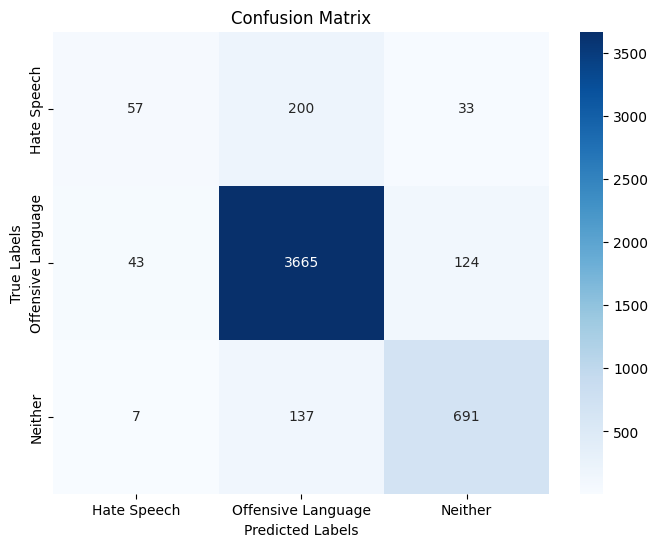

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming y_true contains the true labels and y_pred contains the predicted labels
# y_true and y_pred should be 1D arrays or lists

# Compute confusion matrix
cm = confusion_matrix(y_true, y_preds)

# Define class labels
class_names = ['Hate Speech', 'Offensive Language', 'Neither']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [48]:
import numpy as np

label_mapping = {
    0: 'Hate Speech',
    1: 'Offensive Language',
    2: 'Neither'
}

custom_text = ["I will kill you"]

custom_text = [remove_punctuations(text) for text in custom_text]
custom_text = [remove_stopwords(text) for text in custom_text]

custom_text_seq = token.texts_to_sequences(custom_text)
custom_text_pad = pad_sequences(custom_text_seq, maxlen=50, padding='post', truncating='post')

custom_predictions = model.predict(custom_text_pad)

custom_labels = np.argmax(custom_predictions, axis=1)

mapped_custom_labels = [label_mapping[label] for label in custom_labels]

print("Predicted Labels:", mapped_custom_labels)

1/1 [==============================] - 0s 64ms/step
Predicted Labels: ['Offensive Language']


In [61]:
model.save('model.h5')

In [63]:
import pickle
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(token, tokenizer_file)